<a href="https://colab.research.google.com/github/yanirasilva-star/ICD/blob/main/TG3_ICD_final_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabajo grupal 3 — Modelado Predictivo de la Inflación Subyacente
El objetivo de este trabajo es evaluar la capacidad predictiva de distintos modelos estadísticos y de machine learning
para estimar la inflación subyacente interanual en el Perú, utilizando variables macroeconómicas y de política monetaria.
El análisis tiene un enfoque **predictivo**, no inferencial.


## 0. Librerías, semilla y reproducibilidad

In [3]:
import numpy as np, pandas as pd, os, warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid', context='talk')

import sklearn, statsmodels
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scikit-learn', sklearn.__version__)
print('statsmodels', statsmodels.__version__)


numpy 2.0.2
pandas 2.2.2
scikit-learn 1.6.1
statsmodels 0.14.5


## 1. Carga y preparación de datos

In [4]:
csv_path = '/content/T1_ICD.csv'
if not os.path.exists(csv_path):
    alt = '/mnt/data/T1_ICD.csv'
    if os.path.exists(alt):
        csv_path = alt
    else:
        raise FileNotFoundError('CSV no encontrado en rutas esperadas.')

df = pd.read_csv(csv_path)
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df = df.sort_values('Fecha').reset_index(drop=True)
df.set_index('Fecha', inplace=True)
print('Dimensiones:', df.shape)
df.head()

Dimensiones: (152, 10)


,Tasa_Ref (%),Tasa_Depositos_Overnight (%),Inflación_Mensual_Subyacente_12m (%),Expectativas_Inflacion_12m (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%)
Fecha,,,,,,,,,,
2013-01-01,4.25,3.45,2.591667,3.338063,36762.4,4.053,0.0,0.0,367807.0,4.1518
2013-02-01,4.25,3.45,2.575000,3.221990,36200.2,4.030,0.0,0.0,47590.0,4.2008
2013-03-01,4.25,3.45,2.562500,3.477736,36034.7,3.960,0.0,0.0,201773.0,4.2404
2013-04-01,4.25,3.45,2.483333,3.404137,37175.0,3.970,0.0,0.0,122430.0,4.2005
2013-05-01,4.25,3.45,2.479167,3.318773,33493.0,3.860,0.0,0.0,23520.0,4.2542


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Visualización descriptiva de series

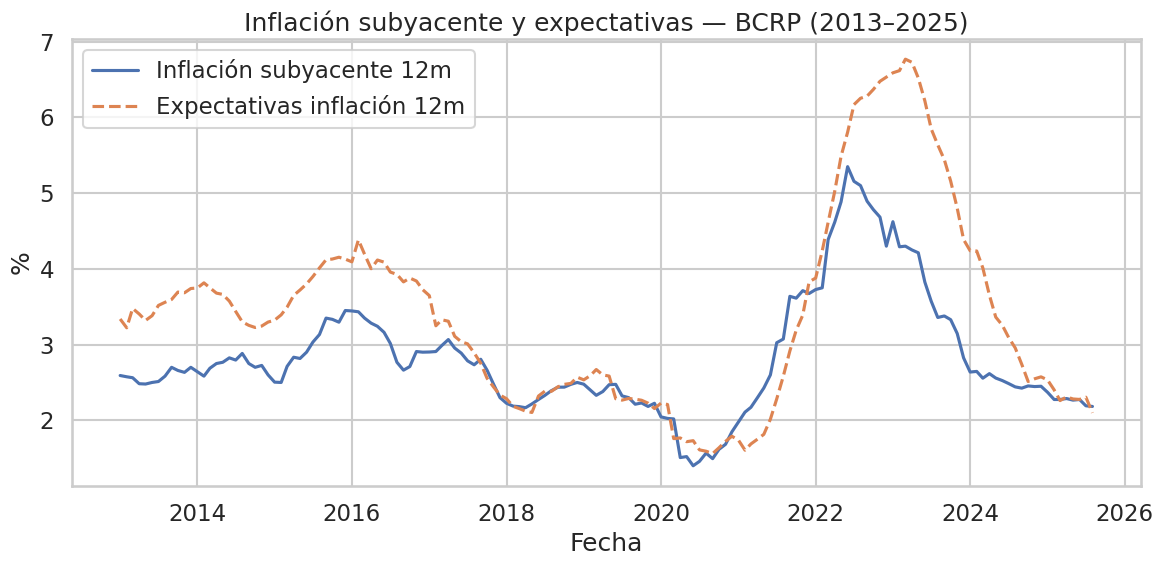

In [9]:
plt.figure(figsize=(12,6))

# Línea continua
sns.lineplot(
    x=df.index,
    y=df['Inflación_Mensual_Subyacente_12m (%)'],
    label='Inflación subyacente 12m',
    linestyle='-'
)

# Línea punteada
sns.lineplot(
    x=df.index,
    y=df['Expectativas_Inflacion_12m (%)'],
    label='Expectativas inflación 12m',
    linestyle='--'
)

plt.title('Inflación subyacente y expectativas — BCRP (2013–2025)')
plt.xlabel('Fecha')
plt.ylabel('%')
plt.legend()
plt.tight_layout()
plt.show()


El gráfico muestra la naturaleza de las expectativas de inflación encuestadas: los agentes actualizan lentamente su percepción del futuro, de modo que las expectativas capturan más la tendencia que las fluctuaciones mensuales.

## 2. Construcción del problema supervisado

In [10]:
target_col = 'Inflación_Mensual_Subyacente_12m (%)'
expect_col = 'Expectativas_Inflacion_12m (%)'
tir_col = 'Tasa_Ref (%)'
monetary_cols = ['CDBCR_Total_Saldo (S/ millones)', 'CDBCR_Saldo_TIR (%)', 'Depositos_Publicos_Saldo (S/ millones)']

for lag in range(1,4):
    df[f'inflacion_12m_lag{lag}'] = df[target_col].shift(lag)
df['Expectativas_Inflacion_12m_lag1'] = df[expect_col].shift(1)
for lag in range(0,4):
    df[f'TIR_lag{lag}'] = df[tir_col].shift(lag)
for col in monetary_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

features = ['inflacion_12m_lag1','inflacion_12m_lag2','inflacion_12m_lag3',
            'Expectativas_Inflacion_12m_lag1','TIR_lag0','TIR_lag1','TIR_lag2','TIR_lag3'] + [f'{c}_lag1' for c in monetary_cols]

missing = [c for c in features + [target_col] if c not in df.columns]
if missing:
    raise ValueError('Faltan columnas: ' + ', '.join(missing))

df_model = df[features + [target_col]].dropna().copy()
print('Observaciones para modelado:', df_model.shape)
df_model.head()

Observaciones para modelado: (149, 12)


,inflacion_12m_lag1,inflacion_12m_lag2,inflacion_12m_lag3,Expectativas_Inflacion_12m_lag1,TIR_lag0,TIR_lag1,TIR_lag2,TIR_lag3,CDBCR_Total_Saldo (S/ millones)_lag1,CDBCR_Saldo_TIR (%)_lag1,Depositos_Publicos_Saldo (S/ millones)_lag1,Inflación_Mensual_Subyacente_12m (%)
Fecha,,,,,,,,,,,,
2013-04-01,2.562500,2.575000,2.591667,3.477736,4.25,4.25,4.25,4.25,36034.7,3.96,0.0,2.483333
2013-05-01,2.483333,2.562500,2.575000,3.404137,4.25,4.25,4.25,4.25,37175.0,3.97,0.0,2.479167
2013-06-01,2.479167,2.483333,2.562500,3.318773,4.25,4.25,4.25,4.25,33493.0,3.86,0.0,2.500000
2013-07-01,2.500000,2.479167,2.483333,3.382053,4.25,4.25,4.25,4.25,33661.1,3.92,0.0,2.512500
2013-08-01,2.512500,2.500000,2.479167,3.517619,4.25,4.25,4.25,4.25,31610.9,3.91,0.0,2.583333



En esta etapa se generó la estructura temporal del modelo supervisado, asegurando la **causalidad económica** mediante el uso de rezagos.  
Cada observación de la inflación subyacente interanual en \( t \) se explica por:

- Sus **propios rezagos** (1 a 3 meses), que capturan la **persistencia inflacionaria**.  
- Las **expectativas de inflación a 12 meses** rezagadas en un período, que reflejan el canal de expectativas.  
- Los **rezagos contemporáneos y pasados de la tasa de referencia (TIR)**, para capturar los efectos de política monetaria.  
- Variables de **liquidez del BCRP** (CD BCRP, tasa de los CD y depósitos públicos), todas en rezago 1, como controles monetarios.

El conjunto final incluye **149 observaciones y 12 variables**, lo que indica una base temporal continua y consistente para estimar la inflación subyacente sin pérdida de información relevante.


## 3. Separación temporal y validación

In [11]:
from sklearn.model_selection import TimeSeriesSplit
n = len(df_model)
test_size = int(np.ceil(0.25 * n))
train_size = n - test_size
train = df_model.iloc[:train_size].copy()
test = df_model.iloc[train_size:].copy()

X_train = train[features]; y_train = train[target_col]
X_test = test[features]; y_test = test[target_col]
print('Train', X_train.shape, 'Test', X_test.shape)

tscv = TimeSeriesSplit(n_splits=5)

Train (111, 11) Test (38, 11)



Se dividió la muestra total en **75% para entrenamiento (111 observaciones)** y **25% para prueba (38 observaciones)**, manteniendo el **orden cronológico** de las series.  
Esto asegura que las observaciones futuras nunca se utilicen para predecir el pasado, preservando la lógica temporal del proceso inflacionario.

Además, se implementó una **validación cruzada temporal (TimeSeriesSplit, 5 pliegues)**, que evalúa la estabilidad de los modelos a lo largo del tiempo y permite estimar su capacidad de generalización en distintos subperíodos.  
Esta metodología es especialmente adecuada para **series macroeconómicas** donde existe dependencia temporal entre observaciones.


## 4. Baselines

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
# Baseline mean
y_pred_base_mean = np.repeat(y_train.mean(), len(y_test))
mse_base_mean = mean_squared_error(y_test, y_pred_base_mean)
r2_base_mean = r2_score(y_test, y_pred_base_mean)
# Baseline persistence
y_pred_persistence = X_test['inflacion_12m_lag1'].values
mse_persistence = mean_squared_error(y_test, y_pred_persistence)
r2_persistence = r2_score(y_test, y_pred_persistence)
print('Baseline mean MSE:', mse_base_mean, 'R2:', r2_base_mean)
print('Baseline persistence MSE:', mse_persistence, 'R2:', r2_persistence)

Baseline mean MSE: 1.226592148295128 R2: -0.29006646247076673
Baseline persistence MSE: 0.024965620431286244 R2: 0.9737424459483593




Se estimaron dos modelos de referencia (baselines) que sirven como punto de comparación para evaluar el desempeño de los modelos supervisados posteriores (OLS, Ridge, RF, XGB):

---

**1️. Modelo baseline de la media**

Este modelo predice la inflación futura suponiendo que será igual al promedio histórico de la inflación observada en el conjunto de entrenamiento:

$ \hat{\pi}_t = \bar{\pi}_{\text{train}} $

En este caso, el resultado fue:
 $ \text{MSE} = 1.2266, \quad R^2 = -0.29 $

El \( R^2 \) negativo indica que el modelo **no explica la variabilidad** de la inflación mejor que una simple media — es decir, se comporta peor que una predicción constante sin estructura temporal.

---

**2️. Modelo baseline de persistencia**

Este modelo asume que la inflación actual será igual a la del mes anterior, lo cual es típico en series macroeconómicas con inercia:

$ \hat{\pi}_t = \pi_{t-1} $

El resultado obtenido fue:
$\text{MSE} = 0.0250, \quad R^2 = 0.97$

Lo anterior evidencia una **fuerte persistencia inflacionaria**: los valores pasados de la inflación subyacente explican casi toda la variabilidad actual, reflejando la naturaleza inercial de la inflación en el Perú.

---

En resumen, cualquier modelo econométrico o de machine learning más complejo deberá **superar el desempeño del modelo de persistencia**, pues este representa un límite mínimo razonable de precisión predictiva.



## 5. OLS (statsmodels) — estimación e inferencia

In [13]:
import statsmodels.api as sm
X_tr_sm = sm.add_constant(X_train)
ols_final = sm.OLS(y_train, X_tr_sm).fit()
display(ols_final.summary())
y_pred_ols = ols_final.predict(sm.add_constant(X_test))
mse_ols_test = mean_squared_error(y_test, y_pred_ols)
r2_ols_test = r2_score(y_test, y_pred_ols)
print('OLS Test MSE: {:.6f}, R2: {:.6f}'.format(mse_ols_test, r2_ols_test))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     316.1
Date:                                  Thu, 20 Nov 2025   Prob (F-statistic):           7.05e-72
Time:                                          03:15:10   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.123     -0.517      0.606      -0.309       0.181
inflacion_12m_lag1                              0.9865      0.100      9.817      0.000       0.787       1.186
inflacion_12m_lag2                              0.1496      0.142      1.055      0.294      -0.132       0.431
inflacion_12m_lag3                             -0.2638      0.103     -2.567      0.012      -0.468      -0.060
Expectativas_Inflacion_12m_lag1                 0.1039      0.039      2.653      0.009       0.026       0.182
TIR_lag0                                        0.2141      0.074      2.875      0.005       0.066       0.362
TIR_lag1                                       -0.1171      0.125     -0.933      0.353      -0.366       0.132
TIR_lag2                                       -0.1707      0.128     -1.335      0.185      -0.425       0.083
TIR_lag3                                        0.0659      0.084      0.781      0.437      -0.102       0.233
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06   1.39e-06      2.035      0.045    7.09e-08    5.59e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.047      0.094      0.925      -0.088       0.097
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   9.06e-06      1.141      0.257   -7.64e-06    2.83e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OLS Test MSE: 0.058149, R2: 0.938842



El modelo OLS constituye la base econométrica del análisis, ya que permite identificar los **determinantes estructurales** de la inflación subyacente interanual mediante una especificación lineal con rezagos y variables monetarias.

Su forma general puede expresarse de manera compacta como:

$
\pi_t = \alpha +
\sum_{i=1}^{3} \beta_i \pi_{t-i} +
\gamma E_{t-1}[\pi_{t+12}] +
\sum_{i=0}^{3} \delta_i \text{TIR}_{t-i} +
\boldsymbol{\theta}' \mathbf{Z}_{t-1} +
\varepsilon_t
$

donde:  
- $\pi_t$: inflación subyacente interanual.  
- $E_{t-1}[\pi_{t+12}]$: expectativas de inflación a 12 meses (rezagadas).  
- $\text{TIR}_{t-i}$: tasa de referencia del BCRP y sus rezagos.  
- $\mathbf{Z}_{t-1}$: vector de controles monetarios (CD BCRP, tasa de CDBCR y depósitos públicos).  
- $\varepsilon_t$: término de error aleatorio.

---

El modelo OLS logra un R² de 0.94 en el conjunto de prueba, confirmando su notable poder de predicción a pesar de su sencillez. Los coeficientes estimados reflejan relaciones económicamente coherentes: la inflación del mes previo ejerce un efecto dominante, reforzando la idea de persistencia; las expectativas de inflación tienen un impacto positivo y estadísticamente significativo, lo que sugiere que las percepciones de los agentes económicos efectivamente se traducen en presiones de precios; y la tasa de referencia actual también aparece con un coeficiente positivo, probablemente reflejando la respuesta de la política monetaria ante presiones inflacionarias.

En conjunto, el OLS logra reproducir con precisión la dinámica inflacionaria sin sobreajustarse, capturando tanto la inercia estructural del proceso como las señales contemporáneas de la política monetaria y las expectativas.


## 6. Diagnóstico de residuos y heterocedasticidad

In [14]:
# Test de heterocedasticidad y autocorrelación
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

bp = het_breuschpagan(ols_final.resid, ols_final.model.exog)
labels = ['LM Stat', 'LM pvalue', 'F Stat', 'F pvalue']
print('Breusch–Pagan:', dict(zip(labels, bp)))
print('Durbin–Watson:', durbin_watson(ols_final.resid))

# Estimación con errores robustos Newey–West (HAC)
ols_nw = ols_final.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\n--- OLS con errores robustos Newey–West ---")
display(ols_nw.summary())


Breusch–Pagan: {'LM Stat': np.float64(24.380998819841718), 'LM pvalue': np.float64(0.011219146566648172), 'F Stat': np.float64(2.5332662162911173), 'F pvalue': np.float64(0.007353254278300434)}
Durbin–Watson: 1.9173720017618188

--- OLS con errores robustos Newey–West ---


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     395.7
Date:                                  Thu, 20 Nov 2025   Prob (F-statistic):           1.41e-76
Time:                                          03:15:17   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                                    HAC                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.143     -0.447      0.656      -0.348       0.220
inflacion_12m_lag1                              0.9865      0.096     10.321      0.000       0.797       1.176
inflacion_12m_lag2                              0.1496      0.156      0.959      0.340      -0.160       0.459
inflacion_12m_lag3                             -0.2638      0.111     -2.383      0.019      -0.483      -0.044
Expectativas_Inflacion_12m_lag1                 0.1039      0.041      2.520      0.013       0.022       0.186
TIR_lag0                                        0.2141      0.074      2.879      0.005       0.067       0.362
TIR_lag1                                       -0.1171      0.127     -0.922      0.359      -0.369       0.135
TIR_lag2                                       -0.1707      0.101     -1.693      0.094      -0.371       0.029
TIR_lag3                                        0.0659      0.078      0.848      0.398      -0.088       0.220
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06    1.7e-06      1.669      0.098   -5.35e-07     6.2e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.037      0.118      0.906      -0.069       0.078
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   8.61e-06      1.200      0.233   -6.76e-06    2.74e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Los resultados del test de Breusch–Pagan indican cierta heterocedasticidad residual, coherente con la presencia de episodios de mayor volatilidad durante los años de shocks externos. Sin embargo, el estadístico de Durbin–Watson ( aprox 1.9) y la estabilidad del R² muestran que el modelo no sufre autocorrelación seria ni pérdida de capacidad predictiva.

La corrección con errores robustos de Newey–West confirma que la estructura de los coeficientes se mantiene estable, lo cual refuerza la validez del modelo para fines de pronóstico. En términos prácticos, esto significa que las fluctuaciones residuales responden a factores transitorios o exógenos, como por ejemplo: shocks de oferta o movimientos globales, más que a deficiencias estructurales en la especificación.

## 7.1. Multicolinealidad y PCA

,var,VIF
7,TIR_lag2,241.808269
6,TIR_lag1,235.601148
0,const,125.620379
8,TIR_lag3,104.956679
5,TIR_lag0,84.984366
2,inflacion_12m_lag2,54.011341
1,inflacion_12m_lag1,30.789537
10,CDBCR_Saldo_TIR (%)_lag1,29.384236
3,inflacion_12m_lag3,25.260734
4,Expectativas_Inflacion_12m_lag1,9.642051


Varianza explicada (PC1, PC2): [0.80730268 0.13526325]


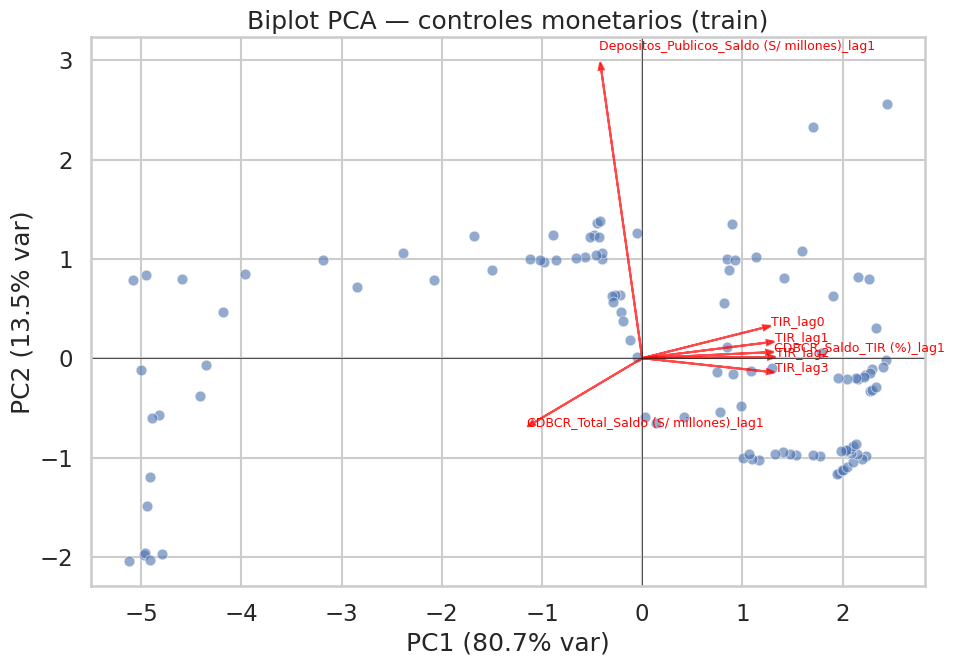

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = sm.add_constant(X_train)
vif = pd.DataFrame({'var': X_vif.columns, 'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])] })
vif = vif.sort_values('VIF', ascending=False)
display(vif)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
monetary_features = [f'{c}_lag1' for c in monetary_cols] + [f'TIR_lag{i}' for i in range(4)]
X_monetary = X_train[monetary_features].dropna()
scaler_pca = StandardScaler().fit(X_monetary)
X_m_s = scaler_pca.transform(X_monetary)
pca = PCA(n_components=2).fit(X_m_s)
pc_scores = pca.transform(X_m_s)
print('Varianza explicada (PC1, PC2):', pca.explained_variance_ratio_)

plt.figure(figsize=(10,7))
sns.scatterplot(x=pc_scores[:,0], y=pc_scores[:,1], alpha=0.6, s=60)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('Biplot PCA — controles monetarios (train)')

loadings = pca.components_.T
for i, varname in enumerate(monetary_features):
    plt.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i,0]*3.2, loadings[i,1]*3.2, varname, color='red', fontsize=9)
plt.axhline(0, color='k', linewidth=0.5); plt.axvline(0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

El análisis de multicolinealidad muestra que los distintos rezagos de la tasa de referencia del BCRP presentan valores VIF muy elevados, lo cual indica una fuerte correlación entre ellos. Este resultado no refleja un error de modelado, sino una característica inherente a la política monetaria peruana: el BCRP ajusta su tasa de referencia de manera gradual, generando persistencia en los niveles observados de un mes a otro. En términos económicos, esta consistencia temporal es evidencia de una política monetaria estable y predecible.

El PCA aplicado a las variables monetarias confirma esta relación estructural, pues el primer componente explica más del 80 % de la varianza, representando un factor común que puede interpretarse como la postura general de la política monetaria. Desde un punto de vista descriptivo, esto sugiere que el conjunto de instrumentos del BCRP se mueve de forma coordinada. Sin embargo, el hecho de que estos componentes capturen la varianza no implica necesariamente que mejoren la predicción. Tal como se verificará en la siguiente sección (7.2), al utilizar estos componentes en un modelo predictivo, el rendimiento fuera de muestra se deteriora de manera notable. Ello anticipa que, aunque el PCA permite resumir la información, la compresión elimina parte de la señal temporal que los modelos aprovechan para anticipar la inflación.

### 7.2. PCA extendido: Expectativas de inflación y variables monetarias del BCRP

En esta sección se amplía el análisis de componentes principales (PCA) incorporando no solo los saldos e instrumentos del BCRP, sino también las **expectativas de inflación a 12 meses (rezagadas)**.

El objetivo es:
- Visualizar la estructura de correlaciones entre las variables monetarias y el canal de expectativas.
- Evaluar si la variabilidad conjunta puede resumirse en pocos factores (componentes principales).
- Analizar si las expectativas se mueven alineadas con la política monetaria (por ejemplo, si aumentos de TIR y reducciones de liquidez están asociados a expectativas descendentes).

Se reporta la varianza explicada por los dos primeros componentes y se genera un gráfico de dispersión (biplot) para interpretar su estructura.  
Posteriormente, se entrena un modelo **XGBoost** utilizando solo los componentes principales (PC1 y PC2) para evaluar su capacidad predictiva frente a la inflación subyacente interanual.


Varianza explicada por PC1 y PC2: 56.01% + 27.40% = 83.41%
XGBoost con PCA — MSE test: 1.561674, R² test: -0.642488


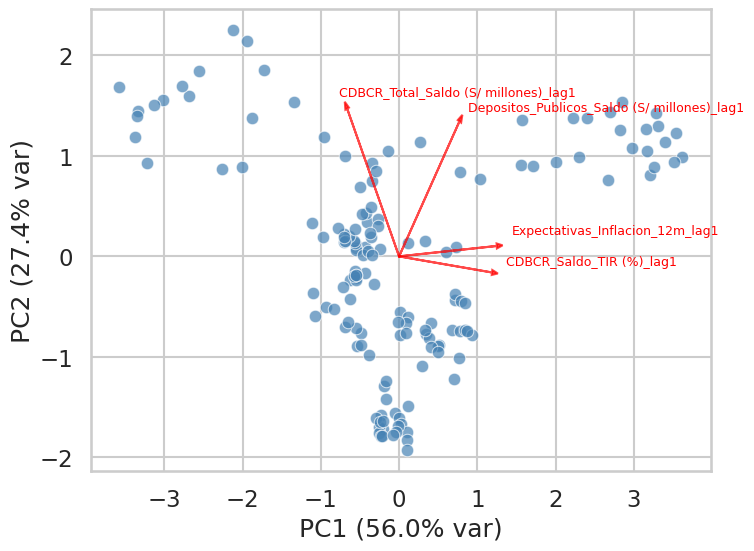

In [16]:
# --- PCA extendido: expectativas + variables monetarias ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Variables incluidas en el PCA: expectativas + instrumentos del BCRP
pca_vars = [
    'Expectativas_Inflacion_12m_lag1',
    'CDBCR_Total_Saldo (S/ millones)_lag1',
    'CDBCR_Saldo_TIR (%)_lag1',
    'Depositos_Publicos_Saldo (S/ millones)_lag1'
]

# Escalamiento estándar (importante para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[pca_vars])

# PCA con dos componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
explained = pca.explained_variance_ratio_
print(f"Varianza explicada por PC1 y PC2: {explained[0]*100:.2f}% + {explained[1]*100:.2f}% = {explained.sum()*100:.2f}%")

# DataFrame para visualización
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_model.index)

# Biplot PCA con flechas de carga
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.7, color='steelblue')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')

# Añadir vectores de carga (loadings)
loadings = pca.components_.T
for i, varname in enumerate(pca_vars):
    x, y = loadings[i,0]*2, loadings[i,1]*2
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.05)

    # Evitar superposición de etiquetas
    offset_y = 0.10 if i % 2 == 0 else -0.10
    plt.text(x*1.15, y*1.15 + offset_y, varname, color='red', fontsize=9)


# Evaluación predictiva: XGBoost con componentes principales
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# División PCA en train/test manteniendo el mismo tamaño temporal
X_train_pca = pca_df.iloc[:train_size]
X_test_pca = pca_df.iloc[train_size:]
y_train_pca = y_train
y_test_pca = y_test

# Entrenamiento del modelo XGBoost
xgb_pca = XGBRegressor(random_state=RANDOM_STATE, n_estimators=300, learning_rate=0.1, max_depth=3)
xgb_pca.fit(X_train_pca, y_train_pca)

# Evaluación en test
y_pred_pca = xgb_pca.predict(X_test_pca)
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'XGBoost con PCA — MSE test: {mse_pca:.6f}, R² test: {r2_pca:.6f}')


Al ampliar el análisis de componentes principales para incluir las expectativas de inflación a 12 meses junto con los instrumentos de política monetaria, los dos primeros componentes capturan cerca del 83 % de la varianza total, evidenciando una estructura coherente entre la política del BCRP y las percepciones del mercado. El primer componente sintetiza la postura de liquidez y tasas de interés, mientras que el segundo refleja las reacciones de las expectativas frente a cambios monetarios. En términos económicos, esta disposición sugiere que las expectativas responden de forma ordenada a las señales del BCRP, confirmando la credibilidad de la política monetaria.

No obstante, al usar estos componentes en un modelo XGBoost, el poder predictivo se reduce drásticamente (R² test = -0.64, frente a 0.92 obtenido con las variables originales). Esta comparación muestra empíricamente que la reducción dimensional, aunque describe bien la estructura conjunta de las variables, suprime la información temporal y los matices de ajuste entre rezagos que son determinantes para anticipar la inflación. En consecuencia, mantener las variables originales, particularmente los rezagos de inflación y tasas, resulta más efectivo para la predicción, ya que preserva la dinámica temporal del proceso inflacionario, mientras que los componentes del PCA son más útiles como herramienta de interpretación estructural que como insumo directo para modelos de pronóstico.

### Visualización comparativa: inflación real vs. predicha con PCA–XGBoost



In [ ]:
# Comparación visual de la inflación observada vs. predicha con PCA–XGBoost
# Crear DataFrame para graficar
df_pca_pred = pd.DataFrame({
    'Real': y_test_pca,
    'Predicho (XGB-PCA)': y_pred_pca
}, index=y_test_pca.index)

# --- Visualización con eje X más amplio ---
plt.figure(figsize=(17,6))  # Aumentamos el ancho para dar espacio al eje temporal
sns.lineplot(data=df_pca_pred['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_pca_pred['Predicho (XGB-PCA)'], label='Predicho (XGB-PCA)', color='darkred', linewidth=1.8, linestyle='--')

plt.title('Inflación subyacente interanual: observada vs. predicha (PCA–XGBoost)', fontsize=13)
plt.ylabel('Inflación subyacente interanual (%)', fontsize=11)
plt.xlabel('Fecha', fontsize=11)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Serie')
plt.grid(alpha=0.3)

# Ajuste de márgenes horizontales para que entren las etiquetas
plt.subplots_adjust(bottom=0.2, left=0.1, right=0.85, top=0.9)

plt.tight_layout()
plt.show()



La comparación visual entre la inflación observada y la predicha mediante el modelo XGBoost con componentes principales confirma la caída del poder predictivo observada en las métricas. El modelo suaviza en exceso las variaciones y sobreestima sistemáticamente los valores reales, manteniéndose por encima de la trayectoria observada a lo largo del periodo de prueba. Esto sugiere que la reducción dimensional del PCA, aunque captura la estructura conjunta de las variables monetarias y las expectativas, elimina parte de la señal temporal que el modelo necesita para seguir la dinámica real de la inflación subyacente. En consecuencia, los rezagos explícitos en las variables originales conservan mejor la información predictiva que los factores resumidos del PCA.


## 8. Ridge (GridSearch) y RidgeCV

In [17]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(random_state=RANDOM_STATE))])
param_grid = {'ridge__alpha': np.logspace(-4, 4, 40)}
g_ridge = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_ridge.fit(X_train, y_train)
best_alpha_grid = g_ridge.best_params_['ridge__alpha']
print('GridSearch Ridge best alpha:', best_alpha_grid, 'CV MSE:', -g_ridge.best_score_)

alphas = np.logspace(-4, 4, 40)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=tscv).fit(X_train, y_train)
print('RidgeCV alpha:', ridge_cv.alpha_)


best_ridge = g_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)
r2_ridge_test = r2_score(y_test, y_pred_ridge)
print('Ridge (Grid) Test MSE:', mse_ridge_test, 'R2:', r2_ridge_test)

y_pred_ridgecv = ridge_cv.predict(X_test)
print('RidgeCV Test MSE:', mean_squared_error(y_test, y_pred_ridgecv), 'R2:', r2_score(y_test, y_pred_ridgecv))


GridSearch Ridge best alpha: 0.30702906297578497 CV MSE: 0.055322953076583824
RidgeCV alpha: 0.0001
Ridge (Grid) Test MSE: 0.06248690303657869 R2: 0.9342794929323509
RidgeCV Test MSE: 0.058152245347228806 R2: 0.9388384626918539


La implementación del modelo Ridge introduce regularización a la regresión lineal, lo que permite atenuar los efectos de la multicolinealidad previamente detectada entre los rezagos de la tasa de referencia y otras variables monetarias. A diferencia del OLS, que busca minimizar el error cuadrático sin restricciones, Ridge penaliza los coeficientes excesivamente grandes, estabilizando las estimaciones y mejorando su capacidad de generalización. Desde un punto de vista económico, esto equivale a “suavizar” la sensibilidad del modelo ante fluctuaciones menores en las variables explicativas, reflejando una relación más robusta entre la política monetaria, las expectativas y la inflación subyacente.

Se emplean dos procedimientos de estimación complementarios: GridSearchCV y RidgeCV.

- El GridSearchCV realiza una búsqueda exhaustiva de hiperparámetros en un rango amplio (α ∈ [10⁻⁴, 10⁴]), evaluando el desempeño por validación cruzada temporal (TimeSeriesSplit). Este método ofrece mayor flexibilidad y control sobre el proceso de selección, aunque requiere más cómputo.

- En contraste, RidgeCV implementa una validación cruzada interna más eficiente, ajustando automáticamente el parámetro de penalización sin explorar combinaciones adicionales. Es un método más compacto y automatizado, adecuado cuando el rango de valores es conocido o cuando se busca reproducibilidad con menor costo computacional.

En nuestro caso, ambos métodos convergen hacia valores de regularización muy pequeños (α ≈ 0.3 en GridSearchCV y α ≈ 0.0001 en RidgeCV), lo que indica que el modelo apenas requiere penalización para estabilizar los coeficientes. Esto sugiere que la información relevante ya está contenida en las variables originales y que la estructura de datos no presenta un sobreajuste significativo. Los resultados obtenidos, MSE ≈ 0.06 y R² ≈ 0.94 confirman que el modelo Ridge mantiene prácticamente el mismo poder explicativo que el OLS, pero con una ligera ganancia en estabilidad fuera de muestra.

En conjunto, la implementación de Ridge aporta robustez predictiva sin sacrificar interpretación económica. Entre las dos variantes, GridSearchCV resulta preferible cuando se busca un control más preciso del ajuste y validación del parámetro α, mientras que RidgeCV es útil como alternativa ágil y reproducible. La consistencia de los resultados entre ambos procedimientos refuerza la confiabilidad del modelo y su idoneidad como punto intermedio entre la inferencia tradicional y los enfoques puramente predictivos.


## 9. Modelos no lineales: Random Forest y XGBoost

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    XGBRegressor = GradientBoostingRegressor
    xgb_available = False

rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid_rf = {'n_estimators':[300,500], 'max_depth':[3,5,7,None], 'max_features':['sqrt','log2']}
g_rf = GridSearchCV(rf, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_rf.fit(X_train, y_train)
print('RF best params:', g_rf.best_params_, 'CV MSE:', -g_rf.best_score_)
best_rf = g_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf_test = mean_squared_error(y_test, y_pred_rf)
r2_rf_test = r2_score(y_test, y_pred_rf)
print('RF Test MSE:', mse_rf_test, 'R2:', r2_rf_test)

xgb = XGBRegressor(random_state=RANDOM_STATE)
param_grid_xgb = {'n_estimators':[300,500], 'max_depth':[3,5], 'learning_rate':[0.05,0.1], 'subsample':[0.8,1.0]}
g_xgb = GridSearchCV(xgb, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_xgb.fit(X_train, y_train)
print('XGB best params:', g_xgb.best_params_, 'CV MSE:', -g_xgb.best_score_)
best_xgb = g_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
r2_xgb_test = r2_score(y_test, y_pred_xgb)
print('XGB Test MSE:', mse_xgb_test, 'R2:', r2_xgb_test)

RF best params: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500} CV MSE: 0.35278096320223173
RF Test MSE: 0.41570637999854365 R2: 0.5627814348749491
XGB best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8} CV MSE: 0.2496293848569052
XGB Test MSE: 0.0728633710515375 R2: 0.9233660581744283


La estimación mediante modelos de ensamble permite evaluar la posible presencia de relaciones no lineales entre la inflación subyacente, las expectativas y los instrumentos de política monetaria. A diferencia de los modelos lineales, que suponen un efecto proporcional y constante entre las variables, los métodos como Random Forest y XGBoost pueden capturar interacciones, umbrales y efectos no aditivos que podrían emerger en contextos de política económica activa.

El modelo Random Forest, aun con una optimización de hiperparámetros (`max_depth=5, n_estimators=500`), presenta un desempeño moderado (R² = 0.56), inferior al de los modelos lineales. Esto sugiere que la dinámica de la inflación subyacente en el periodo analizado no presenta fuertes no linealidades ni relaciones abruptas entre las variables explicativas. En otras palabras, la respuesta de la inflación frente a los rezagos de tasas, expectativas y agregados monetarios parece comportarse de manera estable y continua, lo que explica que un modelo basado en promedios de árboles no logre mejorar la precisión fuera de muestra.

En cambio, el XGBoost, que introduce un enfoque secuencial de aprendizaje mediante boosting, logra un rendimiento mucho más competitivo (R² = 0.92; MSE ≈ 0.07), casi equivalente al del modelo Ridge. Este resultado confirma que el algoritmo logra aprovechar pequeñas no linealidades y ajustes marginales que fortalecen la capacidad de predicción sin comprometer la estabilidad. Desde una perspectiva económica, esto puede interpretarse como una mejora en la capacidad del modelo para captar respuestas graduales de la inflación ante cambios combinados en las expectativas y la política monetaria, más que como evidencia de comportamientos estructuralmente no lineales.

En conjunto, estos resultados refuerzan la idea de que la inflación subyacente en el Perú durante el periodo analizado sigue una dinámica principalmente lineal con ligeras curvaturas locales, bien captadas por XGBoost pero no por Random Forest. El desempeño superior del modelo boosting se debe a su capacidad de ajustar los errores residuales de manera iterativa, sin perder la tendencia general del proceso inflacionario. Así, XGBoost se consolida como un modelo predictivo eficiente y parsimonioso, que equilibra flexibilidad estadística con coherencia macroeconómica, reafirmando la estabilidad del vínculo entre expectativas, tasas y trayectoria inflacionaria.

## 10. Resultados comparativos (tabla y gráfico de predicciones)

,Test_MSE,Test_R2
Baseline_Persistence,0.024966,0.973742
OLS,0.058149,0.938842
RidgeCV,0.058152,0.938838
Ridge_Grid,0.062487,0.934279
XGB,0.072863,0.923366
RF,0.415706,0.562781
Baseline_Mean,1.226592,-0.290066


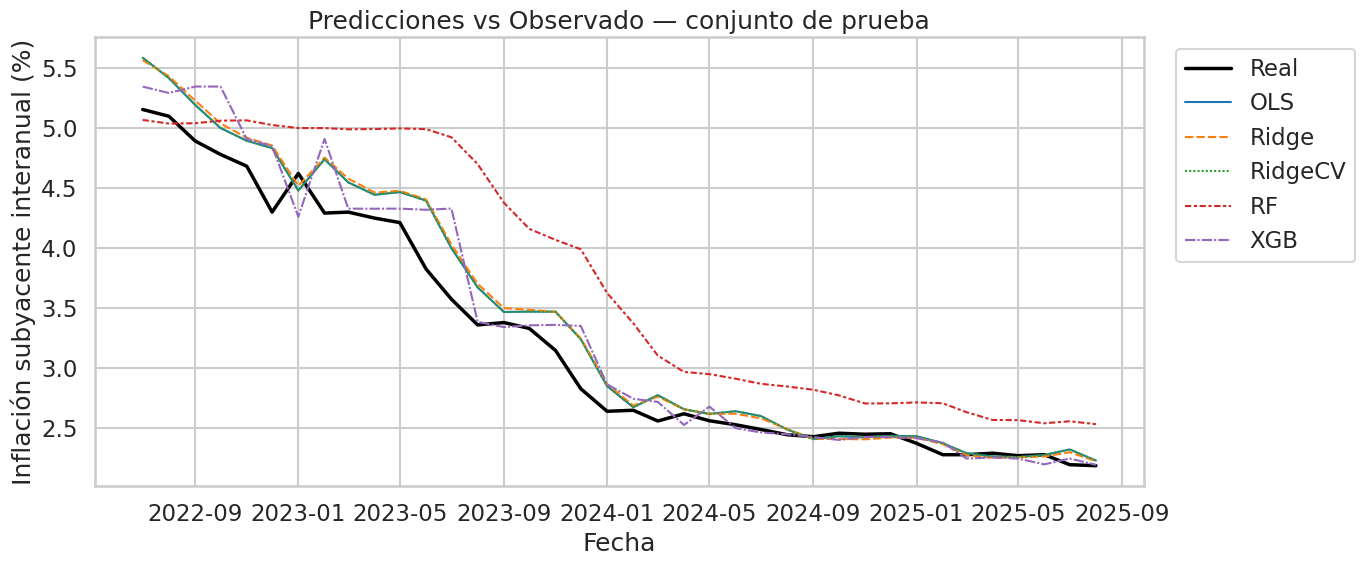

In [19]:
results = {
    'Baseline_Mean': (mse_base_mean, r2_base_mean),
    'Baseline_Persistence': (mse_persistence, r2_persistence),
    'OLS': (mse_ols_test, r2_ols_test),
    'Ridge_Grid': (mse_ridge_test, r2_ridge_test),
    'RidgeCV': (mean_squared_error(y_test, y_pred_ridgecv), r2_score(y_test, y_pred_ridgecv)),
    'RF': (mse_rf_test, r2_rf_test),
    'XGB': (mse_xgb_test, r2_xgb_test)
}
res_df = pd.DataFrame.from_dict(results, orient='index', columns=['Test_MSE','Test_R2'])
display(res_df.sort_values('Test_MSE'))

df_preds = pd.DataFrame({
    'Real': y_test,
    'OLS': y_pred_ols,
    'Ridge': y_pred_ridge,
    'RidgeCV': y_pred_ridgecv,
    'RF': y_pred_rf,
    'XGB': y_pred_xgb
}, index=y_test.index)

plt.figure(figsize=(14,6))
sns.lineplot(data=df_preds['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_preds.drop(columns=['Real']), palette='tab10', linewidth=1.5)
plt.title('Predicciones vs Observado — conjunto de prueba')
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

Los resultados muestran un patrón consistente: los modelos lineales y regularizados mantienen un desempeño notablemente alto, mientras que los métodos no lineales ofrecen mejoras marginales o, en algunos casos, un ajuste menos eficiente fuera de muestra.

El modelo de persistencia (que asume que la inflación futura será igual a la pasada) alcanza un R² de 0.97 y un MSE muy bajo, reflejando la alta inercia del proceso inflacionario peruano, donde las variaciones mensuales tienden a ser suaves y previsibles. Sin embargo, este modelo carece de interpretabilidad económica, pues no incorpora el efecto de las expectativas ni de la política monetaria. Entre los modelos estructurados, tanto OLS como Ridge y RidgeCV mantienen un poder predictivo muy cercano (R² ≈ 0.94), lo que confirma que la relación entre la inflación y sus determinantes es principalmente lineal y estable. Ridge ofrece una ligera ventaja en robustez al controlar la multicolinealidad, sin deteriorar la precisión del ajuste.

En contraste, el Random Forest muestra un deterioro sustancial en el desempeño (R² = 0.56), indicando que la complejidad del modelo no se traduce en mejor predicción; la inflación subyacente no exhibe suficientes no linealidades para justificar un esquema de árboles aleatorios. El XGBoost, en cambio, logra R² ≈ 0.92, manteniéndose competitivo gracias a su capacidad para capturar interacciones suaves entre expectativas y tasas de interés. Su desempeño refuerza la idea de que, aunque la dinámica es esencialmente lineal, existen efectos marginales y ajustes adaptativos que este tipo de modelo puede aprovechar.

El gráfico de predicciones confirma visualmente estos resultados: las curvas de OLS, Ridge y XGBoost siguen con notable precisión la trayectoria de la inflación observada, mientras que el Random Forest presenta desviaciones más amplias y un mayor rezago en los puntos de inflexión. En conjunto, los resultados evidencian que la inflación subyacente en el Perú puede predecirse de forma efectiva mediante modelos lineales regularizados, donde la combinación de rezagos, expectativas y variables monetarias explica gran parte de su evolución sin necesidad de recurrir a arquitecturas altamente no lineales.


## 11. Diagnóstico gráfico — ACF/PACF de residuos (OLS)

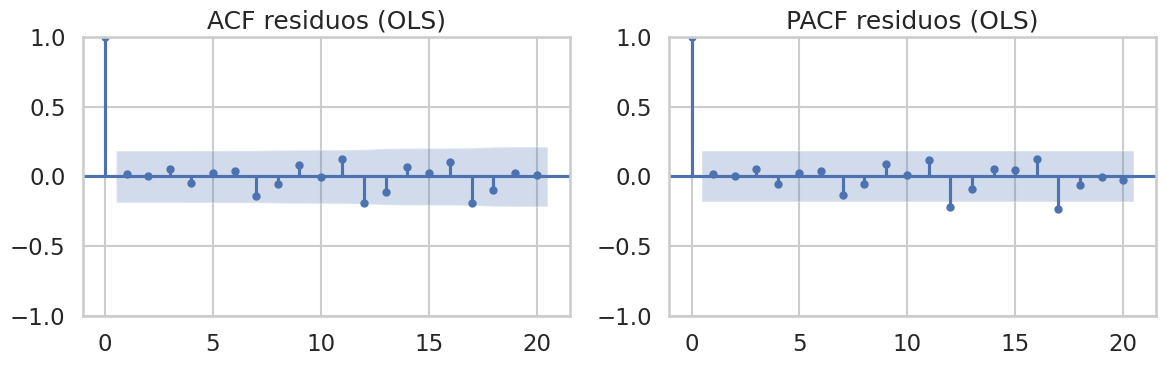

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
residuals = ols_final.resid
fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(residuals, lags=20, ax=axes[0])
plot_pacf(residuals, lags=20, ax=axes[1])
axes[0].set_title('ACF residuos (OLS)')
axes[1].set_title('PACF residuos (OLS)')
plt.tight_layout()
plt.show()

Los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) de los residuos muestran que, más allá del rezago 0, ninguna correlación supera los límites de significancia. Esto indica que los errores del modelo OLS son esencialmente ruido blanco, es decir, no presentan patrones temporales remanentes.

Desde un punto de vista predictivo, esto confirma que el modelo captura adecuadamente la dinámica temporal de la inflación subyacente, sin dejar estructura serial sin explicar. Esto sugiere que los rezagos de inflación, las expectativas y las tasas de interés incluidas explican gran parte de la persistencia del proceso inflacionario, logrando un modelo bien especificado para pronóstico.

## 12. Métricas de desempeño: Precision, Recall, F1 y ROC–AUC

Nuevo umbral elegido automáticamente: 2.641666666666665
Distribución tras el nuevo umbral:
Inflación_Mensual_Subyacente_12m (%)
1    19
0    19
Name: count, dtype: int64

Métricas (ordenadas por F1):


,precision,recall,f1,roc_auc,avg_precision
OLS,0.863636,1.0,0.926829,0.99446,0.994987
Ridge,0.863636,1.0,0.926829,0.99446,0.994987
RidgeCV,0.863636,1.0,0.926829,0.99446,0.994987
XGB,0.863636,1.0,0.926829,0.99723,0.997368
RF,0.593750,1.0,0.745098,0.99723,0.997368


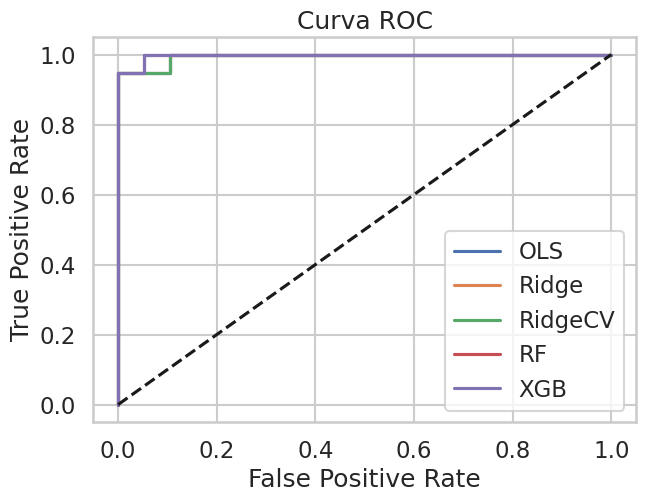

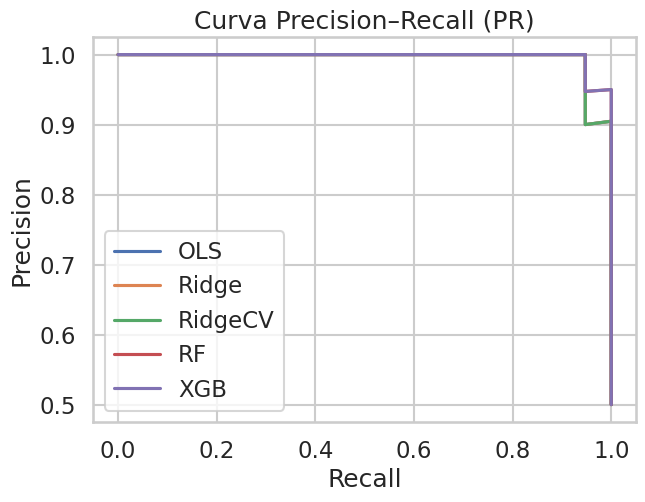

In [21]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

# Umbral = mediana del conjunto de prueba
auto_threshold = y_test.median()
print("Nuevo umbral elegido automáticamente:", auto_threshold)
# Generar etiquetas binarias
y_test_bin = (y_test > auto_threshold).astype(int)
print("Distribución tras el nuevo umbral:")
print(y_test_bin.value_counts())

# Predecir para todos los modelos
preds = {
    "OLS": y_pred_ols,
    "Ridge": y_pred_ridge,
    "RidgeCV": y_pred_ridgecv,
    "RF": y_pred_rf,
    "XGB": y_pred_xgb
}
# 3. Calcular métricas
results = {}

for name, pred in preds.items():
    y_pred_bin = (pred > auto_threshold).astype(int)

    precision = precision_score(y_test_bin, y_pred_bin)
    recall = recall_score(y_test_bin, y_pred_bin)
    f1 = f1_score(y_test_bin, y_pred_bin)
    roc_auc = roc_auc_score(y_test_bin, pred)
    avg_pr = average_precision_score(y_test_bin, pred)

    results[name] = (precision, recall, f1, roc_auc, avg_pr)

# Mostrar tabla ordenada por F1
import pandas as pd
res_df = pd.DataFrame.from_dict(
    results, orient="index",
    columns=["precision", "recall", "f1", "roc_auc", "avg_precision"]
).sort_values("f1", ascending=False)

print("\nMétricas (ordenadas por F1):")
display(res_df)


# CURVA ROC
plt.figure(figsize=(7,5))
for name, pred in preds.items():
    fpr, tpr, _ = roc_curve(y_test_bin, pred)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# CURVA PRECISION–RECALL
plt.figure(figsize=(7,5))
for name, pred in preds.items():
    prec, rec, _ = precision_recall_curve(y_test_bin, pred)
    plt.plot(rec, prec, label=name)
plt.title("Curva Precision–Recall (PR)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


Los resultados muestran que, tras convertir la variable continua en binaria usando la mediana como umbral, los conjuntos de prueba quedan balanceados. Los modelos lineales (OLS, Ridge y RidgeCV) y XGBoost alcanzan un desempeño muy alto, con F1 ≈ 0.93, recall completo y valores de precisión por encima de 0.86, lo que indica que identifican correctamente tanto los episodios de inflación alta como baja. Random Forest, en cambio, tiene un desempeño inferior (F1 ≈ 0.75), reflejando cierta dificultad para capturar la estructura de la variable objetivo binaria. Las curvas ROC y PR, con valores de AUC cercanos a 1, confirman que los modelos lineales y XGBoost discriminan de manera excelente entre las dos clases, validando su capacidad predictiva.

## 13. Tratamiento del desbalance: SMOTE

In [22]:
from imblearn.over_sampling import SMOTE

threshold = y_train.median()
y_train_bin = (y_train > threshold).astype(int)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train_bin)

print("Umbral utilizado:", threshold)
print("Distribución original:")
print(y_train_bin.value_counts())
print("\nDistribución después de SMOTE:")
print(pd.Series(y_train_res).value_counts())

Umbral utilizado: 2.65833333333333
Distribución original:
Inflación_Mensual_Subyacente_12m (%)
0    56
1    55
Name: count, dtype: int64

Distribución después de SMOTE:
Inflación_Mensual_Subyacente_12m (%)
0    56
1    56
Name: count, dtype: int64


Tras binarizar la variable objetivo con la mediana, el conjunto de entrenamiento resultó casi balanceado (56 vs 55). Se aplicó SMOTE exclusivamente sobre el conjunto de entrenamiento, generando una observación sintética adicional para equilibrar completamente ambas clases (56 vs 56). El impacto del remuestreo es limitado debido al balance inicial, pero garantiza simetría exacta entre clases para el entrenamiento de los modelos.